# Introduction to `scikit-learn`: Regression

Here we look at performing a regression task with `scikit-learn`.

`scikit-learn` will be our go to tool to use for quickly trying several machine learning algorithms on a dataset. As we try to use `scikit-learn` for different tasks, we will see that its strengths are:
* Abstracting away the details of many machine learning algorithms so we can focus on training and tuning
* Providing a common interface to many machine learning algorithms so we can quickly try different algorithms
* Providing functions for performing common operations on our datasets including train / test split, some transforms, etc.

While these strengths make `scikit-learn` a powerful tool, we will also see in this class where we need other tools to complement it.
* **Deep learning:** `scikit-learn` has a very limited deep learning capability; for deep learning tasks, we need to use `pytorch` or `tensorflow`.
* **Customization:** `scikit-learn` intentionally abstracts away all implementation details, which makes customization impossible. If we want custom deep learning algorithms, `pytorch` is often regarded as the best tool for the job (though `tensorflow` works too).
* **Use in critical production systems:** `scikit-learn` is built entirely in Python and is not suited for use in critical production systems. Generally, if we need to use machine learning algorithms (like a decision tree ensemble) in a critical production system we will design and train the algorithm with `scikit-learn` and then export it to a standard format to be loaded by a C++ application, or other more robust application written to the standards of the production system.

## Load the Car Sales Data

Our example task involves predicting how much someone will pay for their car based on available data about their personal finances. We use a dataset from Kaggle and make no claims about how realistic or unrealistic it is! As we will see though, the results are impressive.

We start by loading the data with pandas.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

max_iterations = 10000

In [2]:
car_sales_data_path = "./datasets/car_sales/car_purchasing.csv"
car_sales_df = pd.read_csv(car_sales_data_path, encoding="latin-1")

car_sales_df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


We see a few different columns we can use to predict and some that we want to ignore (columns that aren't numeric). The target for our prediction is the "car purchase amount" column.

In [3]:
target_column = "car purchase amount"
features_list = [
    "gender",
    "age",
    "annual Salary",
    "credit card debt",
    "net worth",
]

number_of_rows = len(car_sales_df)
number_of_features = len(features_list)

print(f"Number of rows: {number_of_rows}")
print(f"Number of features: {number_of_features}")
print(f'Target column: "{target_column}"')

Number of rows: 500
Number of features: 5
Target column: "car purchase amount"


## Build a Regressor

Here we use scikit to built a regressor. We use a Multi-Layered Perceptron (MLP) which is a basic type of neural network. We need to do some data massaging to extract a feature matrix and a target vector. Then we use scikit to split the data into training and testing sets. We define a simple MLP structure that gets wide in the middle and then narrows down towards the output. When we instantiate the MLP, we specify some parameters which control how it will train.

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract features matrix
features_df = car_sales_df[features_list]
features_array_x = features_df.to_numpy()

# Extract target vector
target_vector_y = car_sales_df[target_column].to_numpy()
target_vector_y = target_vector_y.reshape(-1, 1).ravel()

print("Feature and target shapes:")
print(features_array_x.shape)
print(target_vector_y.shape)

# Perform a train / test split using sklearn
x_train, x_test, y_train, y_test = train_test_split(
    features_array_x, target_vector_y, test_size=0.2, random_state=42
)

# Define the structure of the neural network we'll train
mlp_structure = (
    number_of_features,
    number_of_features * 4,
    number_of_features * 8,
    number_of_features * 8,
    number_of_features * 4,
    number_of_features,
)

# Standardize the inputs
input_scaler = StandardScaler()
x_train_scaled = input_scaler.fit_transform(x_train)

# Instantiate the regressor with our desired parameters
mlp = MLPRegressor(
    hidden_layer_sizes=mlp_structure,
    max_iter=max_iterations,
    tol=1e-9,
    n_iter_no_change=10,
    activation="relu",
    solver="adam",
    random_state=123,
)

Feature and target shapes:
(500, 5)
(500,)


## Train the Regressor

Here we train the regressor. This step may take a while so we put it in its own cell.

In [5]:
mlp.fit(x_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(5, 20, 40, 40, 20, 5), max_iter=10000,
             random_state=123, tol=1e-09)

## Test the Regressor

Here we test the regressor to see how well it scored on its training and testing datasets. Seeing how the regressor scored on the training data tells us if it actually has the capacity to learn what we are asking it to. Seeing how it performed on the testing data tells us if it will generalize beyond the data we trained it on.

In [6]:
y_hat_train = mlp.predict(x_train_scaled)
train_mse = mean_squared_error(y_train, y_hat_train)

x_test_scaled = input_scaler.transform(x_test)

y_hat_test = mlp.predict(x_test_scaled)
test_mse = mean_squared_error(y_test, y_hat_test)

print(f"Train MSE = {train_mse}")
print(f"Test MSE = {test_mse}")

Train MSE = 30.371096108155847
Test MSE = 7.610941062775879


We can predict the price someone paid for their car almost down to the dollar by using some basic information about their finances. Very cool.

But what if we want to keep our predictions in the DataFrame? Let's use what we know about pandas to do something more custom.

## Use Pandas for More Analysis

Here we create our own train / test split function that allows us to keep working with pandas DataFrames.

In [7]:
import numpy as np

np.random.seed(0)

from ml_data_tools import make_train_test_split_dataframes

x_train, _, y_train, _ = make_train_test_split_dataframes(
    car_sales_df, features_list, target_column, test_fraction=0.2
)

input_scaler = StandardScaler()
x_train_scaled = input_scaler.fit_transform(x_train)

mlp = MLPRegressor(
    hidden_layer_sizes=mlp_structure,
    max_iter=max_iterations,
    tol=1e-9,
    n_iter_no_change=10,
    activation="relu",
    solver="adam",
    random_state=123,
)

In [8]:
mlp.fit(x_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(5, 20, 40, 40, 20, 5), max_iter=10000,
             random_state=123, tol=1e-09)

In [9]:
car_sales_df["predicted purchase amount"] = mlp.predict(
    input_scaler.transform(car_sales_df[features_list].to_numpy())
)
car_sales_df["error"] = (
    car_sales_df["predicted purchase amount"]
    - car_sales_df["car purchase amount"]
)
car_sales_df["percent error"] = (
    (
        car_sales_df["predicted purchase amount"]
        - car_sales_df["car purchase amount"]
    )
    / car_sales_df["car purchase amount"]
    * 100
)

car_sales_df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount,test flag,predicted purchase amount,error,percent error
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877,0.0,35328.824553,7.365783,0.020854
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566,1.0,45112.409708,-3.115952,-0.006907
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921,0.0,42929.212068,3.502858,0.008160
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313,0.0,67451.058899,28.695769,0.042561
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248,0.0,55898.684666,-16.777814,-0.030006


It is good practice to characterize our error per discrete variables that we believe might influence it. Rather than reporting a single average error, it is more helpful in this case to report error per country.

Text(0.5, 1.0, 'Average Percent Error in Car Sales Price Predictions')

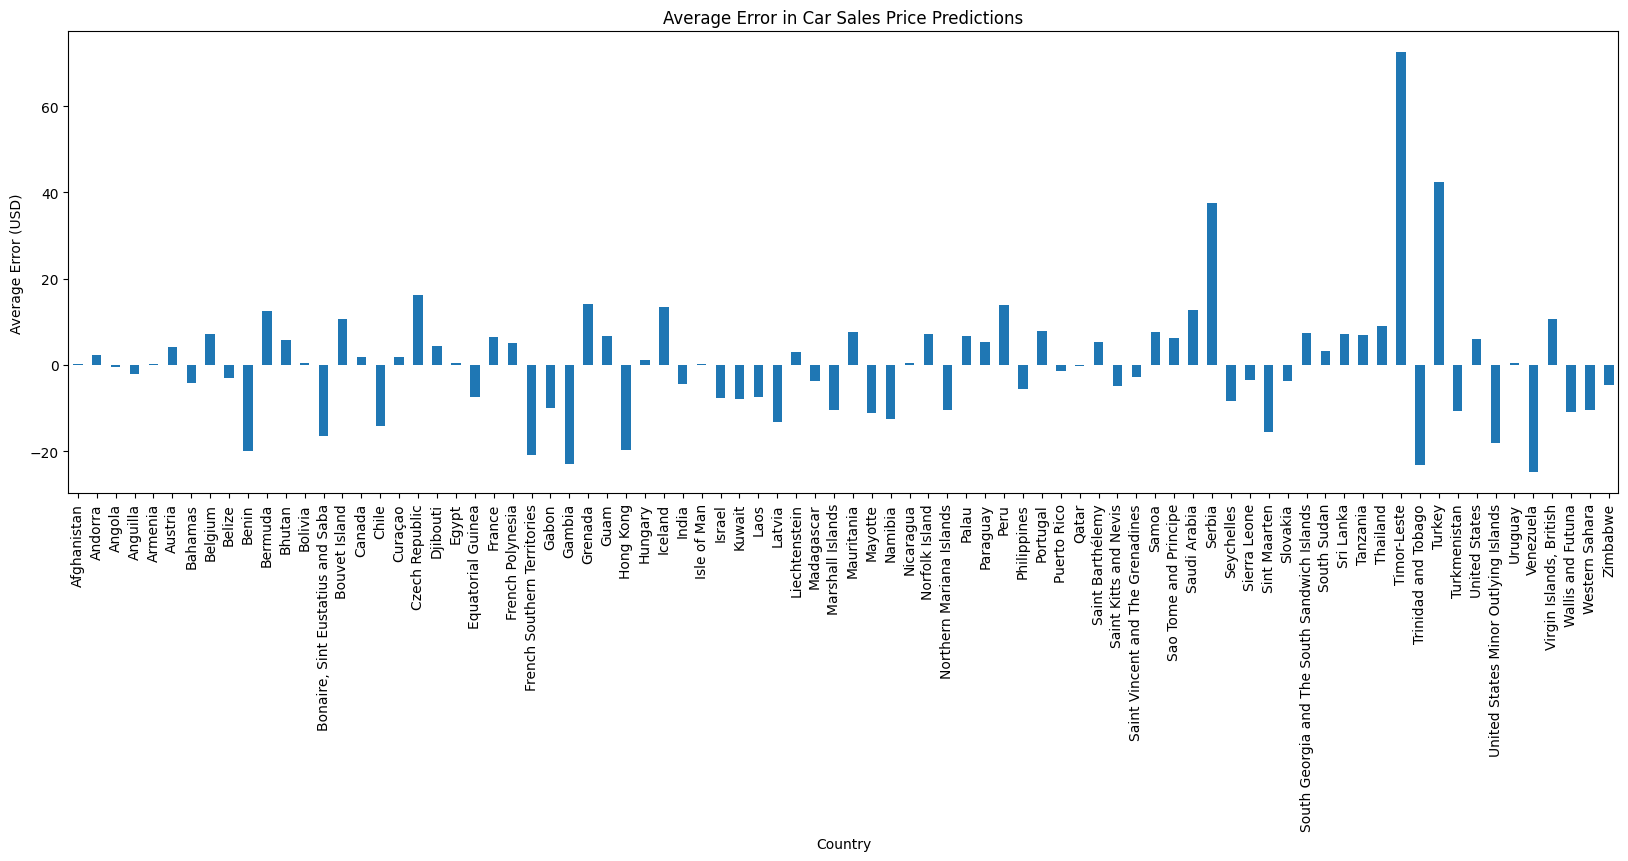

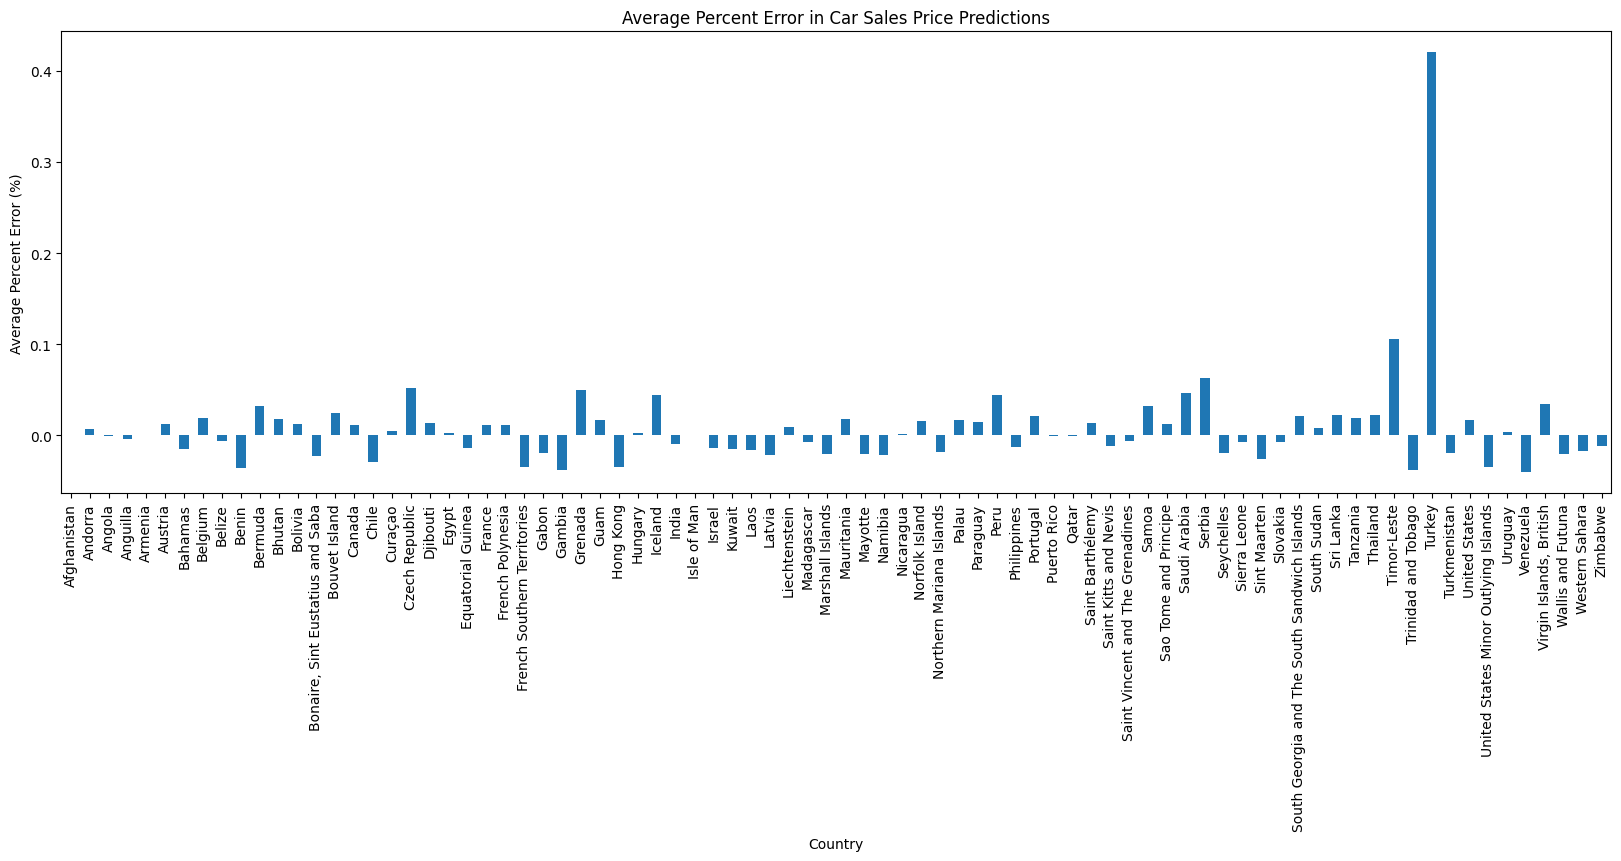

In [10]:
import matplotlib.pyplot as plt

test_only_df = car_sales_df[car_sales_df["test flag"] == 1]

test_error_by_country_df = test_only_df.groupby("country")["error"].mean()
test_percent_error_by_country_df = test_only_df.groupby("country")[
    "percent error"
].mean()

plt.figure(figsize=(20, 6))
test_error_by_country_df.plot.bar()
plt.xlabel("Country")
plt.ylabel("Average Error (USD)")
plt.title("Average Error in Car Sales Price Predictions")

plt.figure(figsize=(20, 6))
test_percent_error_by_country_df.plot.bar()
plt.xlabel("Country")
plt.ylabel("Average Percent Error (%)")
plt.title("Average Percent Error in Car Sales Price Predictions")

Wow! All our predictions are within less than 1% of the true price paid. That is pretty powerful.

### Visualization of the Neural Network Itself

Here we use some custom functions to visualize the neural network itself. If the weights stay towards zero, the network may still have the capacity to fit a harder problem. If the weights are pushed to extreme values, then this might mean the network is reaching its capacity and we need to try a wider or deeper architecture.

Think back to previous discussions of linear and nonlinear transforms and imagine what the network might be doing to solve this problem.

Layer   0:                                                         .  .  .  .  .                                                        
Layer   1:                                                         .  .  .  .  .                                                        
Layer   2:                                   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .                                 
Layer   3:     .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .   
Layer   4:     .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .   
Layer   5:                                   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .                                 
Layer   6:                                                         .  .  .  .  .                                                        
Layer   7:                               

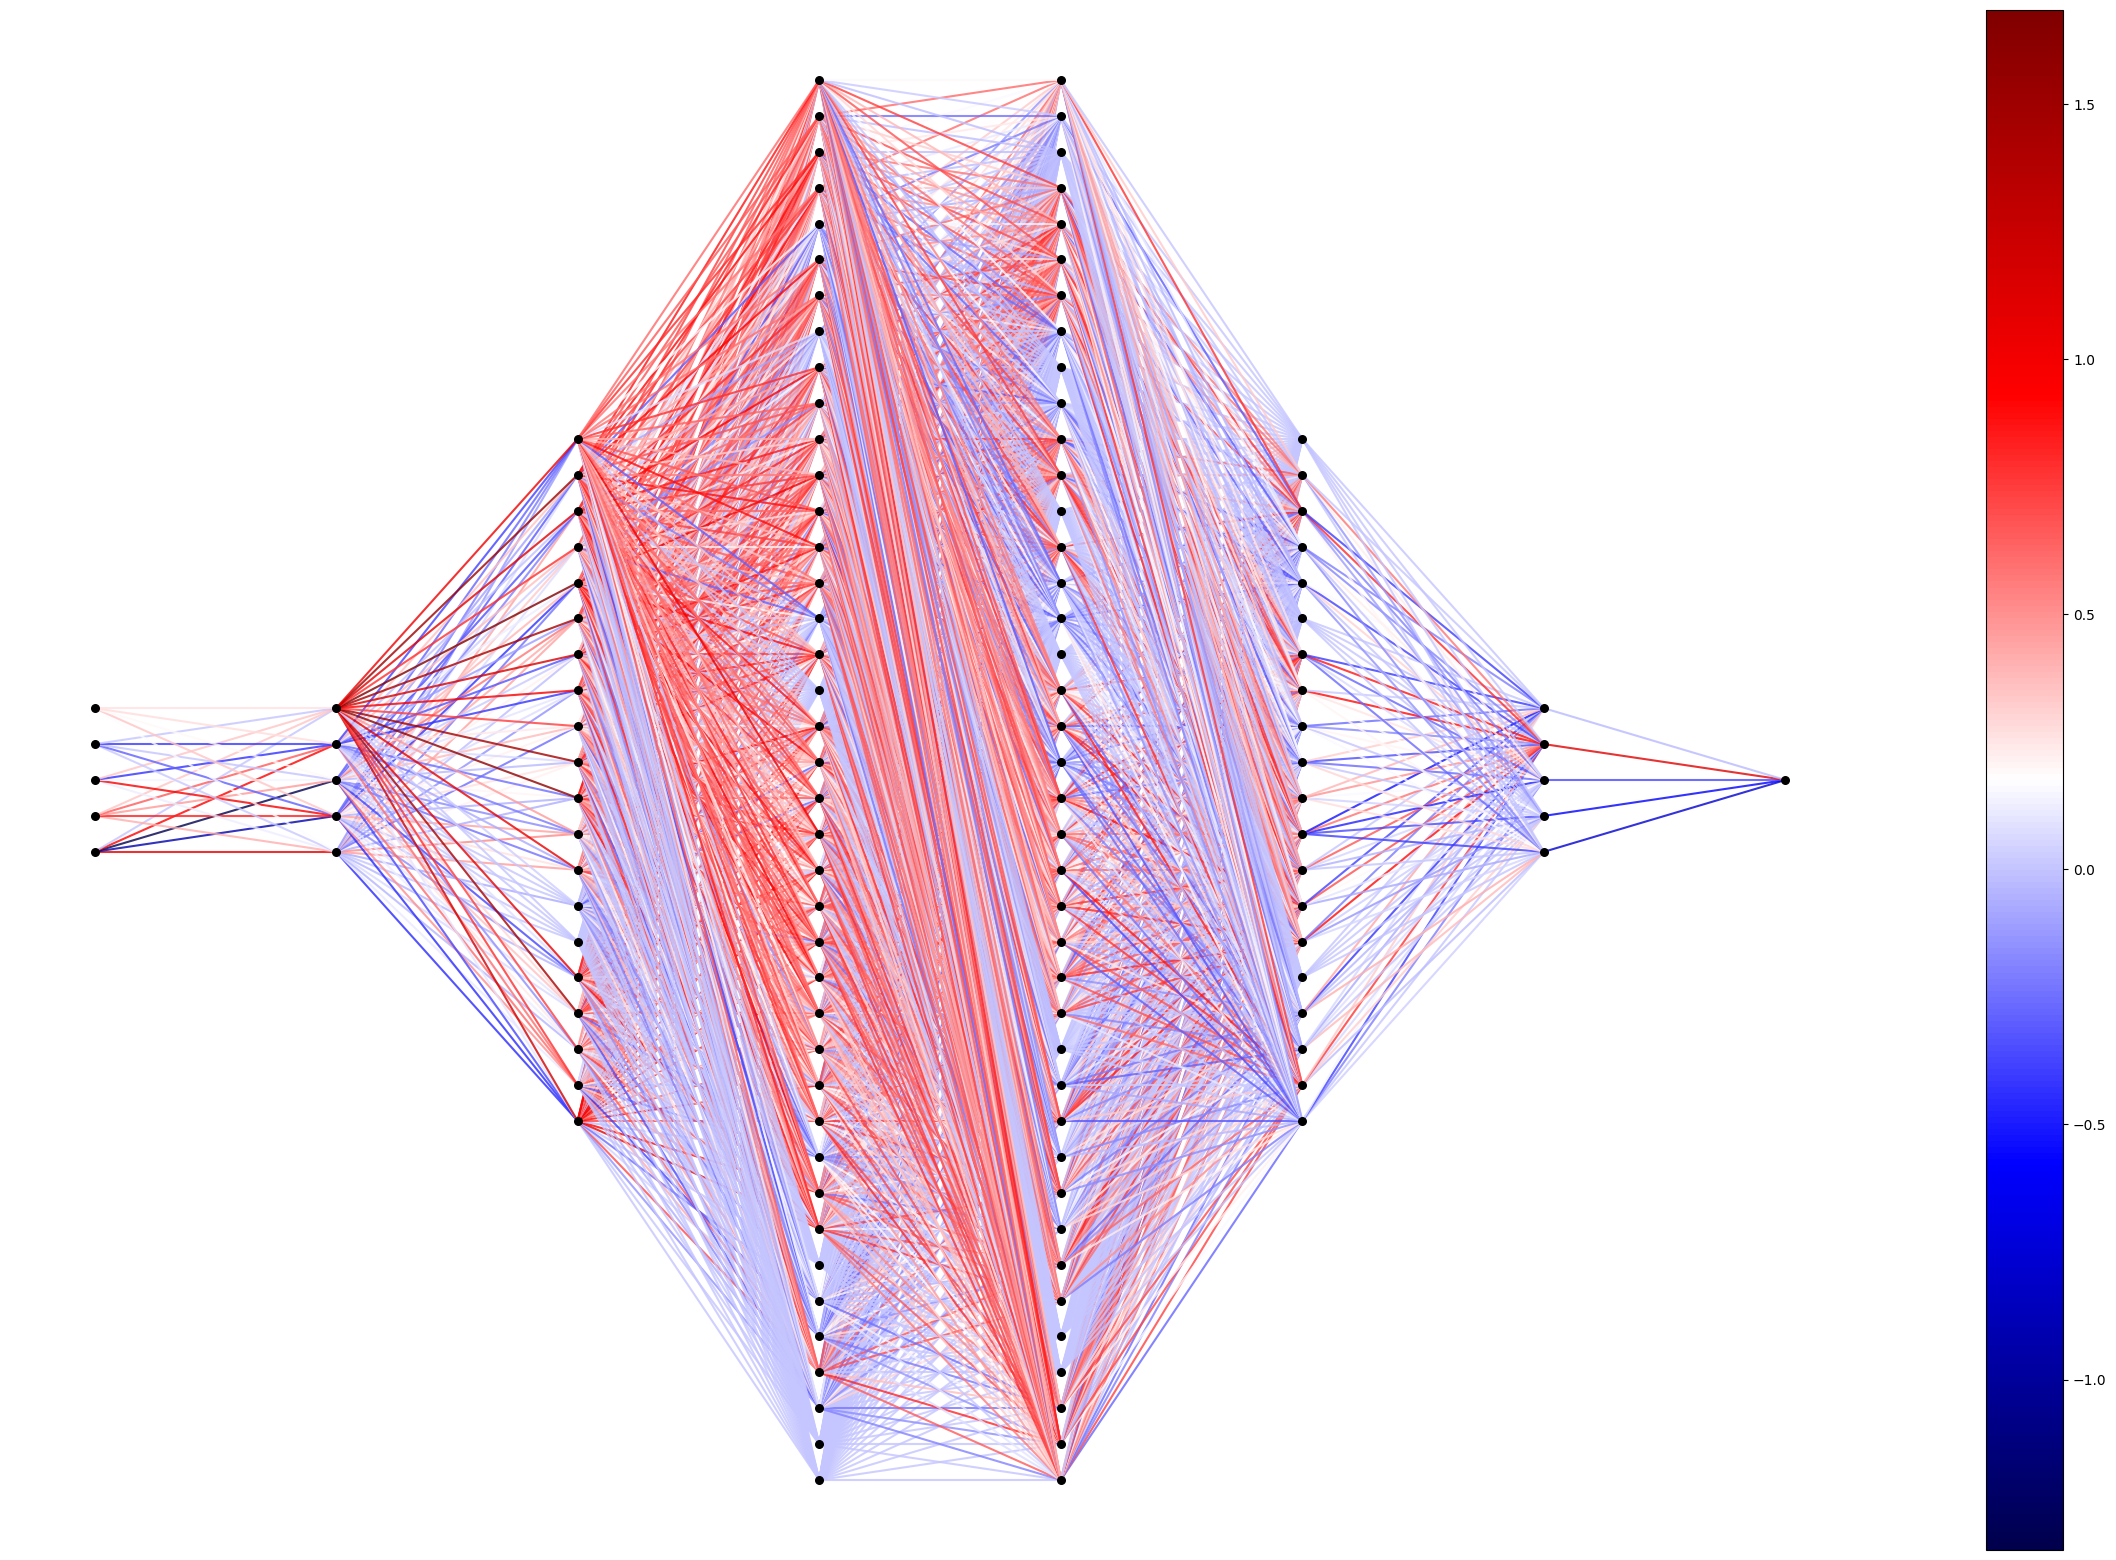

In [11]:
from mlp_visualization import print_ascii_mlp, display_mlp

print_ascii_mlp(mlp)

_ = display_mlp(
    mlp,
    linewidth=1.5,
    neuron_alpha=1,
    neuron_color="black",
    line_alpha=0.8,
    figure_width=30,
    figure_height=20,
    neuron_size=30,
    colormap_name="seismic",
)